## 4 - Partie pratique: estimation de densité 

### 4.1-2

In [338]:
from abc import ABC, abstractmethod
import numpy as np
from scipy.stats import multivariate_normal

from abc import ABC, abstractmethod
import numpy as np
from scipy.stats import multivariate_normal

class Model(ABC):
    @abstractmethod
    def train(self, train_inputs, train_labels):
        pass
    
    @abstractmethod
    def predict(self, test_inputs):
        pass

class Gaussian1d(Model):
    def train(self, train_inputs, train_labels):
        self.mean = np.mean(train_inputs, axis=0)
        self.variance = np.sum((train_inputs - self.mean) ** 2, axis=0) / train_inputs.shape[0]

        #  Test
        assert(np.abs(self.variance - np.var(train_inputs.T)) <= 0.00000000000001)

        self.first_half_pdf = 1 / np.sqrt(2 * np.pi * self.variance)
    
    def logpdf(self, x):
        diff = x - self.mean
        second_half_pdf = np.exp(-0.5 * diff ** 2 / self.variance)
        return np.log(self.first_half_pdf * second_half_pdf)
    
    def predict(self, test_inputs):
        predictions = np.zeros((test_inputs.shape[0]))
        for i, x in enumerate(test_inputs):
            predictions[i] = self.logpdf(x)
            
        return predictions
        
class DiagonalGaussian(Model):   
    def train(self, train_inputs, train_labels):
        # Check if we have more than one dimension because numpy functions like inverse and cov require 2d matrices
        if train_inputs.ndim > 1:
            self.mean = np.mean(train_inputs, axis=0)
            self.covariance = np.diag(np.sum((train_inputs - self.mean) ** 2, axis=0) / train_inputs.shape[0])
            #self.covariance = np.diag(np.diag(np.cov(train_inputs.T)))

            #  Test
            assert((np.abs(self.covariance - np.diag(np.diag(np.cov(train_inputs.T, bias=True)))) <= 0.00000000000001).all())

            self.inv_covariance = np.linalg.inv(self.covariance)
            self.first_half_pdf = 1 / np.sqrt((2 * np.pi) ** train_inputs.shape[1] * np.linalg.det(self.covariance))
            self.compute_log_pdf = self.__logpdf__
        else:
            gaussian1d = Gaussian1d()
            gaussian1d.train(train_inputs, train_labels)
            self.compute_log_pdf = gaussian1d.logpdf
            self.mean = gaussian1d.mean
            self.covariance = gaussian1d.variance
    
    def __logpdf__(self, x):
        diff = x - self.mean
        second_half_pdf = np.exp(-0.5 * np.dot(np.dot(diff, self.inv_covariance), diff))
        return np.log(self.first_half_pdf * second_half_pdf)
    
    def logpdf(self, x):
        return self.compute_log_pdf(x)
    
    def predict(self, test_inputs):
        predictions = np.zeros((test_inputs.shape[0]))
        for i, x in enumerate(test_inputs):
            predictions[i] = self.logpdf(x)
            
        return predictions
    
    def test_predict(self, test_inputs):
        predictions = np.zeros((test_inputs.shape[0], 2))
        for i, x in enumerate(test_inputs):
            predictions[i, 0] = multivariate_normal.logpdf(x, mean=self.mean, cov=self.covariance)
            predictions[i, 1] = self.logpdf(x)
            
        assert((np.abs(predictions[:, 0] - predictions[:, 1]) <= 0.00000000000001).all())

class ParzenIsotropicGaussian(Model):
    def __init__(self, std = 1):
        self.std = std
        
    def train(self, train_inputs, train_labels):
        self.train_inputs = train_inputs
        self.train_labels = train_labels
        
        d = train_inputs.shape[1] if train_inputs.ndim > 1 else 1
        self.first_half_pdf = 1 / ((np.sqrt((2 * np.pi)) * self.std) ** d)
        #self.first_half_pdf = 1 / (np.sqrt((2 * np.pi) ** train_inputs.shape[1] * np.linalg.det(self.covariance)))
    
    def __pdf__(self, x, mean):
        diff = x - mean
        second_half_pdf = np.exp(-0.5 * (np.linalg.norm(diff) / self.std) ** 2)
        #second_half_pdf = np.exp(-0.5 * np.dot(np.dot(diff, self.inv_covariance), diff))
        return self.first_half_pdf * second_half_pdf
    

    def predict(self, test_inputs):
        predictions = np.zeros((test_inputs.shape[0]))
        for i, x in enumerate(test_inputs):
            for X in train_inputs:
                predictions[i] += self.__pdf__(x, X)
                
        predictions /= train_inputs.shape[0]
        return np.log(predictions)
    
    def test_predict(self, test_inputs):
        predictions = np.zeros((test_inputs.shape[0], 2))
        for i, x in enumerate(test_inputs):
            for X in train_inputs:
                predictions[i, 0] += multivariate_normal.pdf(x, mean=X, cov=self.std ** 2)
                predictions[i, 1] += self.__pdf__(x, X)
                
        predictions /= train_inputs.shape[0]
        predictions = np.log(predictions)
        assert((np.abs(predictions[:, 0] - predictions[:, 1]) <= 0.00000000000001).all())


In [318]:
# Test
data = np.loadtxt("./iris.txt")

# Multiple dimensions
train_inputs = data[:50, :4]
train_labels = data[:50, 4]

dg = DiagonalGaussian()
dg.train(train_inputs, train_labels)

parzen = ParzenIsotropicGaussian()
parzen.train(train_inputs, train_labels)

dg.test_predict(data[:50, :4])
parzen.test_predict(data[:50, :4])

# One dimension
train_inputs = data[:50, 0]
train_labels = data[:50, 4]

dg = DiagonalGaussian()
dg.train(train_inputs, train_labels)

parzen = ParzenIsotropicGaussian()
parzen.train(train_inputs, train_labels)

dg.test_predict(data[:50, 0])
parzen.test_predict(data[:50, 0])

### 4.3

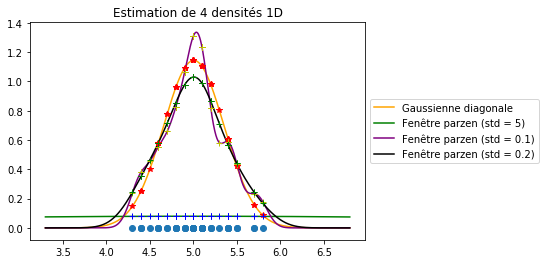

In [372]:
import matplotlib.pyplot as plt
train_inputs = data[:50, 0]
train_labels = data[:50, 4]

feature = data[:50, 0]

min_x = np.min(feature)-1.0
max_x = np.max(feature)+1.0
linespace_indice = np.arange(min_x, max_x, 0.001)

dg = DiagonalGaussian()
dg.train(train_inputs, train_labels)
dg_feature_predictions = dg.predict(feature)
dg_linespace_predictions = dg.predict(linespace_indice)

stdTooLarge = 5
stdTooSmall = 0.1
stdOptimal = 0.2

parzen_stdTooBig = ParzenIsotropicGaussian(std=stdTooLarge)
parzen_stdTooBig.train(train_inputs, train_labels)
parzen_stdTooBig_feature_predictions = parzen_stdTooBig.predict(feature)
parzen_stdTooBig_linespace_predictions = parzen_stdTooBig.predict(linespace_indice)

parzen_stdTooSmall = ParzenIsotropicGaussian(std=stdTooSmall)
parzen_stdTooSmall.train(train_inputs, train_labels)
parzen_stdTooSmall_feature_predictions = parzen_stdTooSmall.predict(feature)
parzen_stdTooSmall_linespace_predictions = parzen_stdTooSmall.predict(linespace_indice)

parzen_stdOptimal = ParzenIsotropicGaussian(std=stdOptimal)
parzen_stdOptimal.train(train_inputs, train_labels)
parzen_stdOptimal_feature_predictions = parzen_stdOptimal.predict(feature)
parzen_stdOptimal_linespace_predictions = parzen_stdOptimal.predict(linespace_indice)

plt.scatter(feature, np.zeros(feature.shape))
# Plot de la gaussienne avec le linespace
plt.plot(linespace_indice, np.exp(dg_linespace_predictions), color='orange')

# Plot de parzen avec le linespace
plt.plot(linespace_indice, np.exp(parzen_stdTooBig_linespace_predictions), color='green')

plt.plot(linespace_indice, np.exp(parzen_stdTooSmall_linespace_predictions), color='purple')

plt.plot(linespace_indice, np.exp(parzen_stdOptimal_linespace_predictions), color='black')

plt.legend(["Gaussienne diagonale", "Fenêtre parzen (std = {})".format(stdTooLarge), "Fenêtre parzen (std = {})".format(stdTooSmall), "Fenêtre parzen (std = {})".format(stdOptimal)], loc='center left', bbox_to_anchor=(1, 0.5))

# Plot de la gaussienne avec les trains data
plt.plot(feature, np.exp(dg_feature_predictions), 'r*')

# Plot de parzen avec le train data
plt.plot(feature, np.exp(parzen_stdTooBig_feature_predictions), 'b+')

plt.plot(feature, np.exp(parzen_stdTooSmall_feature_predictions), 'y+')

plt.plot(feature, np.exp(parzen_stdOptimal_feature_predictions), 'g+')

plt.title("Estimation de 4 densités 1D")

plt.show()

### 4.4

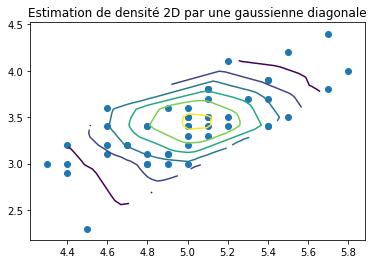

In [347]:
feature = data[:50, :2]
train_inputs = data[:40, :2]
train_labels = data[:50, 4]

xgrid = np.linspace(feature[:,0].min(), feature[:,0].max(), 50)
ygrid = np.linspace(feature[:,1].min(), feature[:,1].max(), 50)
xgrid, ygrid = np.meshgrid(xgrid, ygrid)

dg = DiagonalGaussian()
dg.train(train_inputs, train_labels)
dg_predictions = dg.predict(data[:50, :2])

from scipy.interpolate import griddata
zgrid = griddata(feature, np.exp(dg_predictions), (xgrid, ygrid), method='linear')
plt.scatter(feature[:,0],feature[:,1])
plt.contour(xgrid,ygrid,zgrid)
plt.title("Estimation de densité 2D par une gaussienne diagonale")

plt.show()

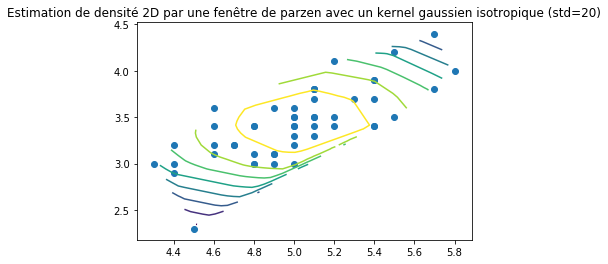

In [368]:
parzen = ParzenIsotropicGaussian(std=20)
parzen.train(train_inputs, train_labels)
parzen_predictions = parzen.predict(data[:50, :2])

from scipy.interpolate import griddata
zgrid = griddata(feature, np.exp(parzen_predictions), (xgrid, ygrid), method='linear')
plt.scatter(feature[:,0],feature[:,1])
plt.contour(xgrid,ygrid,zgrid)
plt.title('''Estimation de densité 2D par une fenêtre de parzen avec un kernel gaussien isotropique (std=20)''')

plt.show()

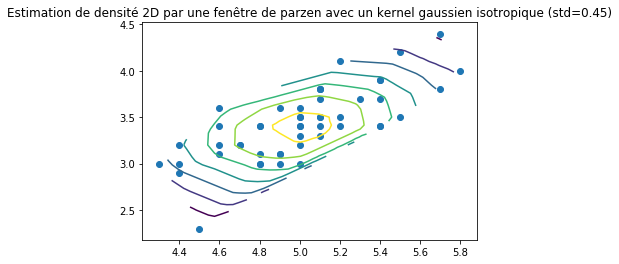

In [367]:
parzen = ParzenIsotropicGaussian(std=0.45)
parzen.train(train_inputs, train_labels)
parzen_predictions = parzen.predict(data[:50, :2])

from scipy.interpolate import griddata
zgrid = griddata(feature, np.exp(parzen_predictions), (xgrid, ygrid), method='linear')
plt.scatter(feature[:,0],feature[:,1])
plt.contour(xgrid,ygrid,zgrid)
plt.title('''Estimation de densité 2D par une fenêtre de parzen avec un kernel gaussien isotropique (std=0.45)''')

plt.show()

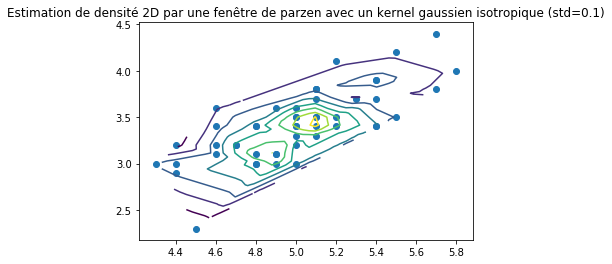

In [366]:
parzen = ParzenIsotropicGaussian(std=0.1)
parzen.train(train_inputs, train_labels)
parzen_predictions = parzen.predict(data[:50, :2])

from scipy.interpolate import griddata
zgrid = griddata(feature, np.exp(parzen_predictions), (xgrid, ygrid), method='linear')
plt.scatter(feature[:,0],feature[:,1])
plt.contour(xgrid,ygrid,zgrid)
plt.title('''Estimation de densité 2D par une fenêtre de parzen avec un kernel gaussien isotropique (std=0.1)''')

plt.show()